# **Device Setup**


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



if (torch.cuda.is_available()):
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


#  **Generating XOR Dataset**


In [7]:
import numpy as np
import torch

def generate_xor_dataset(size):
    n_per_class = size // 4  # Points per quadrant
    
    # First quadrant (x1 in [0.1, 2], x2 in [0.1, 2]), Label: 0
    X_q1 = np.random.uniform(0.1, 2, size=(n_per_class, 2))
    
    # Second quadrant (x1 in [-2, -0.1], x2 in [0.1, 2]), Label: 1
    X_q2 = np.random.uniform(-2, -0.1, size=(n_per_class, 1))
    X_q2 = np.hstack((X_q2, np.random.uniform(0.1, 2, size=(n_per_class, 1))))
    
    # Third quadrant (x1 in [-2, -0.1], x2 in [-2, -0.1]), Label: 0
    X_q3 = np.random.uniform(-2, -0.1, size=(n_per_class, 1))
    X_q3 = np.hstack((X_q3, np.random.uniform(-2, -0.1, size=(n_per_class, 1))))
    
    # Fourth quadrant (x1 in [0.1, 2], x2 in [-2, -0.1]), Label: 1
    X_q4 = np.random.uniform(0.1, 2, size=(n_per_class, 1))
    X_q4 = np.hstack((X_q4, np.random.uniform(-2, -0.1, size=(n_per_class, 1))))
    
    # Combine the quadrants into a single dataset
    X = np.vstack((X_q1, X_q2, X_q3, X_q4))
    
    # Convert the data to torch tensor
    X = torch.FloatTensor(X)
    
    # Labels for XOR logic: XOR(x1 > 0, x2 > 0)
    y = ((X[:, 0] > 0).int() ^ (X[:, 1] > 0).int())  # Convert boolean to int
    
    return X, y
# Example usage
size = 400  # Total number of samples
X, y = generate_xor_dataset(size)



X, y = generate_xor_dataset(400)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# **Visualizing XOR Dataset**

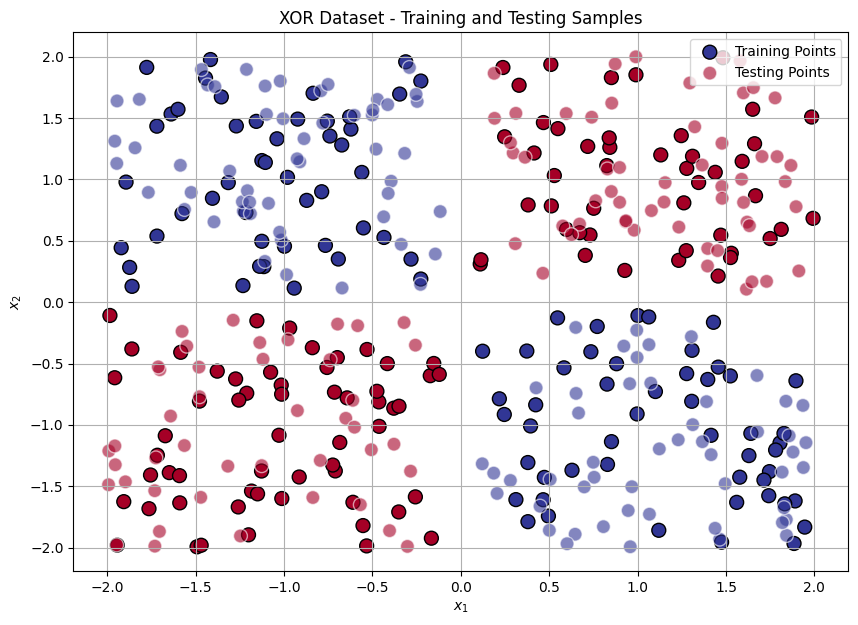

In [3]:
plt.figure(figsize=(10, 7))

# Move tensors to CPU before plotting
X_train_cpu = X_train.cpu().numpy()
X_test_cpu = X_test.cpu().numpy()
y_train_cpu = y_train.cpu().numpy()
y_test_cpu = y_test.cpu().numpy()

# Plot training samples
plt.scatter(X_train_cpu[:, 0], X_train_cpu[:, 1], c=y_train_cpu, cmap="RdYlBu", 
                s=100, label="Training Points",
                edgecolors='black', linewidth=1)

# Plot testing samples
plt.scatter(X_test_cpu[:, 0], X_test_cpu[:, 1], c=y_test_cpu, cmap="RdYlBu", 
                s=100, alpha=0.6, label="Testing Points",
                edgecolors='white', linewidth=1)

plt.title("XOR Dataset - Training and Testing Samples")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.grid(True)
plt.show()


# *Dataset Shapes*

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([200, 2]),
 torch.Size([200, 2]),
 torch.Size([200]),
 torch.Size([200]))

# **Creating XOR MLP Model**

In [8]:
class XORMLP(nn.Module):
    def __init__(self, hidden_layer1, hidden_layer2):
        super().__init__()
        self.lin1 = nn.Linear(2, hidden_layer1)
        self.lin2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.lin3 = nn.Linear(hidden_layer2, 1)

    def forward(self, x):
        x = torch.relu(self.lin1(x))
        x = torch.relu(self.lin2(x))
        logit = self.lin3(x)
        return logit       
    

# **Training and Evaluation Functions**

 ##### $$\sigma(z) = \frac{1}{1 + e^{-z}}$$
 
 #### Without Regulization
 ##### $$\text{Loss} = - \left[y \cdot \log(\sigma(\hat{y})) + (1 - y) \cdot \log(1 - \sigma(\hat{y})) \right]$$
 
 #### L1
 ##### $$\text{Loss} = \text{Binary Cross Entropy with Logits} + \lambda \sum |w|$$
 
 #### L2
 ##### $$\text{Loss} = \text{Binary Cross Entropy with Logits} + \lambda \sum w^2$$

In [6]:
def train_model(model, loss_fn, optimizer, train_loader, regularization_type=None, lamda=0.01, epochs=1000):    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in train_loader:
            # Ensure inputs and targets are on the correct device and type
            inputs = inputs.float().to(device)
            targets = targets.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), targets)
            
            if regularization_type == 'L1':
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss += lamda * l1_norm
            
            elif regularization_type == 'L2':
                l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                loss += lamda * l2_norm
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    
    return epoch_loss

# Define the evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predicted = (outputs.squeeze() > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy


# **Plotting Decision Boundary**

In [7]:
import matplotlib.patches as mpatches

def plot_decision_boundary(X_train, X_test, y_train, y_test, model, title):
    # Move data to CPU and convert to numpy
    X_train_np = X_train.cpu().numpy()
    X_test_np = X_test.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
    # Calculate boundaries
    X = np.vstack([X_train_np, X_test_np])
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Move mesh data to device, get predictions, and move back to CPU
    mesh_data = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(next(model.parameters()).device)
    with torch.no_grad():
        Z = model(mesh_data)
    Z = (Z > 0).float().cpu().numpy().reshape(xx.shape)

    # Create plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.4)

    # Plot the training points
    plt.scatter(X_train_np[:, 0], X_train_np[:, 1], 
                c=y_train_np, cmap="RdYlBu", 
                s=100, label="Training Points",
                edgecolors='black', linewidth=1)
    
    # Plot the testing points
    plt.scatter(X_test_np[:, 0], X_test_np[:, 1], 
                c=y_test_np, cmap="RdYlBu", 
                s=100, alpha=0.6, label="Testing Points",
                edgecolors='white', linewidth=1)

    # Create legend patches
    class1_patch = mpatches.Patch(color='#2166ac', label='Class 0')
    class2_patch = mpatches.Patch(color='#b2182b', label='Class 1')
    pred1_patch = mpatches.Patch(color='#92c5de', label='Predict Class 0')
    pred2_patch = mpatches.Patch(color='#f4a582', label='Predict Class 1')

    # Add legend
    plt.legend(handles=[class1_patch, class2_patch, pred1_patch, pred2_patch],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.15),
               ncol=2,
               fancybox=True,
               shadow=True)

    # Customize plot
    plt.title(title, size=14, pad=20)
    plt.xlabel(r"$x_1$", size=12)
    plt.ylabel(r"$x_2$", size=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


# **Model Without Regulization**

### $$\text{Loss} = - \left[y \cdot \log(\sigma(\hat{y})) + (1 - y) \cdot \log(1 - \sigma(\hat{y})) \right]$$
### $$\sigma(z) = \frac{1}{1 + e^{-z}}$$

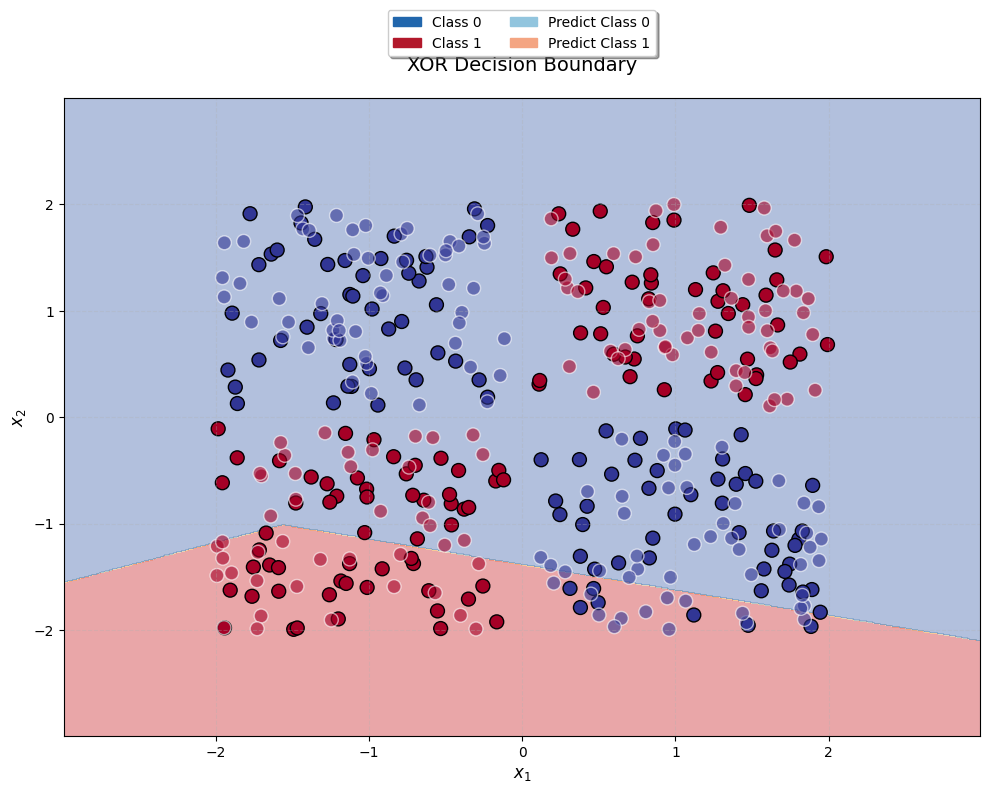

Epoch 1/1000, Loss: 0.6720
Epoch 101/1000, Loss: 0.0008
Epoch 201/1000, Loss: 0.0002
Epoch 301/1000, Loss: 0.0001
Epoch 401/1000, Loss: 0.0000
Epoch 501/1000, Loss: 0.0000
Epoch 601/1000, Loss: 0.0000
Epoch 701/1000, Loss: 0.0000
Epoch 801/1000, Loss: 0.0000
Epoch 901/1000, Loss: 0.0000
Accuracy: 0.9950


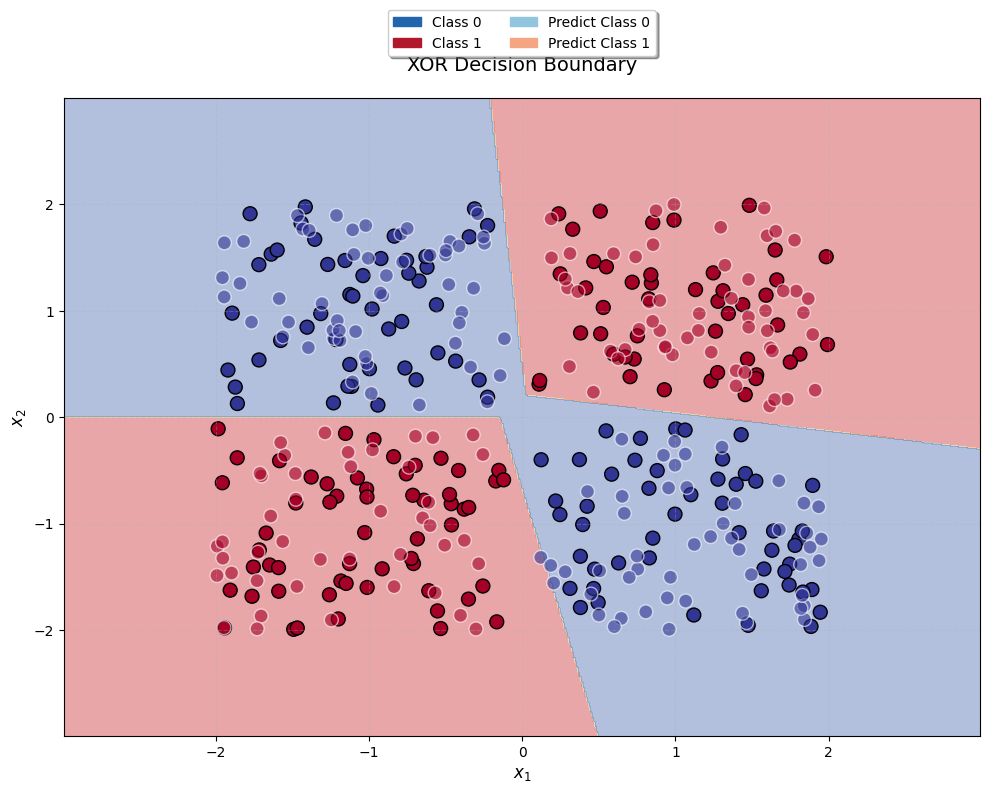

In [8]:
# Convert data to proper types
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.float()  # Convert boolean/long to float
y_test = y_test.float()    # Convert boolean/long to float

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model and move to device
model = XORMLP(3, 2)
model = model.to(device)

# Make sure inputs and targets are on the same device as model
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

# Before Training
plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Decision Boundary")

# Train the model
l1_losses = train_model(model, loss_fn, optimizer, train_loader)
evaluate_model(model, test_loader)

# After Training \
plot_decision_boundary(X_train, X_test, y_train, y_test, model, "XOR Decision Boundary")

# **Training Model With L1 regulization**

### >$$\text{Loss} = \text{Binary Cross Entropy with Logits} + \lambda \sum |w|$$

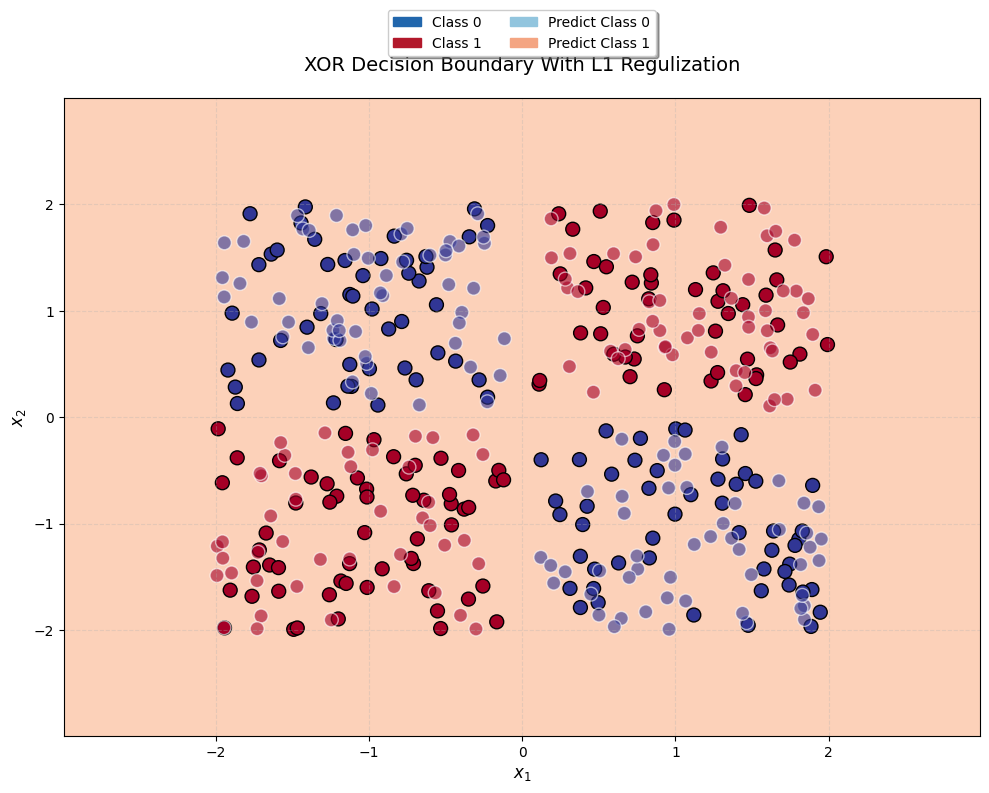

Epoch 1/1000, Loss: 0.6768
Epoch 101/1000, Loss: 0.0474
Epoch 201/1000, Loss: 0.0447
Epoch 301/1000, Loss: 0.0429
Epoch 401/1000, Loss: 0.0421
Epoch 501/1000, Loss: 0.0412
Epoch 601/1000, Loss: 0.0443
Epoch 701/1000, Loss: 0.0413
Epoch 801/1000, Loss: 0.0412
Epoch 901/1000, Loss: 0.0412
Accuracy: 0.9950


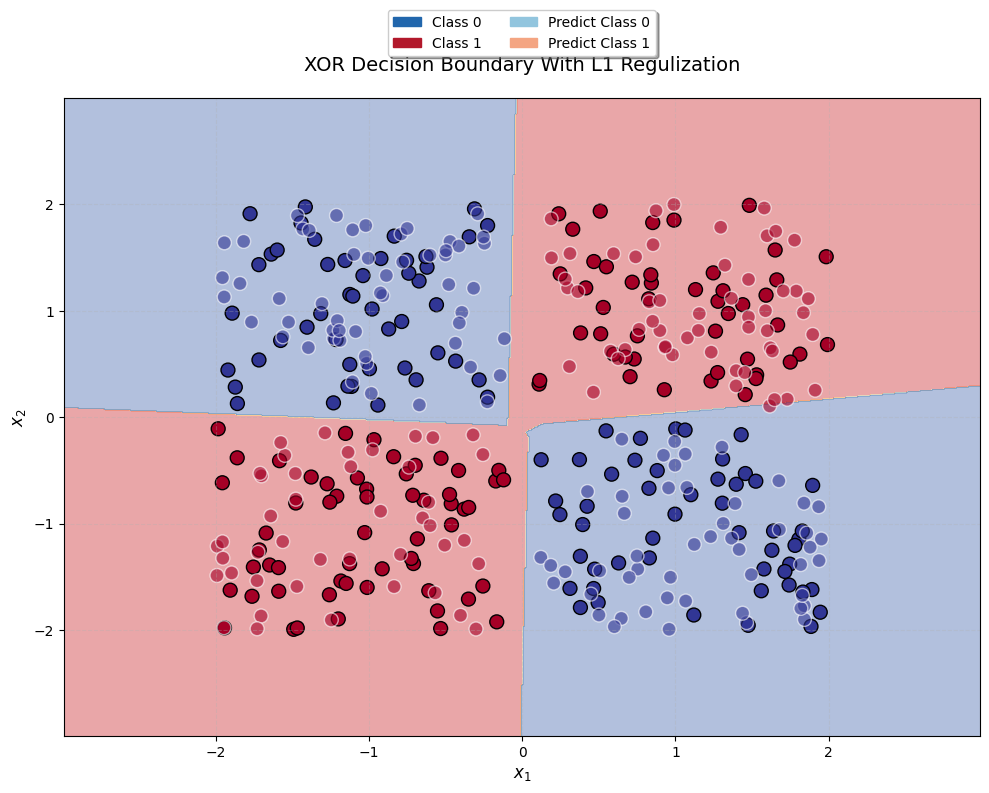

In [9]:
model_L1 = XORMLP(4, 3)
model_L1 = model_L1.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_L1.parameters(), lr=0.03, weight_decay=0)  # No weight decay for L1
    
    
# Before Training
plot_decision_boundary(X_train, X_test, y_train, y_test, model_L1, "XOR Decision Boundary With L1 Regulization")
    
# Train model with L1 regularization
loss_L1 = train_model(model_L1, loss_fn, optimizer, train_loader, regularization_type="L1",lamda=0.001)
evaluate_model(model_L1, test_loader)

# After Training
plot_decision_boundary(X_train, X_test, y_train, y_test, model_L1, "XOR Decision Boundary With L1 Regulization")

# **Training Model With L2 regulization**

### $$\text{Loss} = \text{Binary Cross Entropy with Logits} + \lambda \sum w^2$$

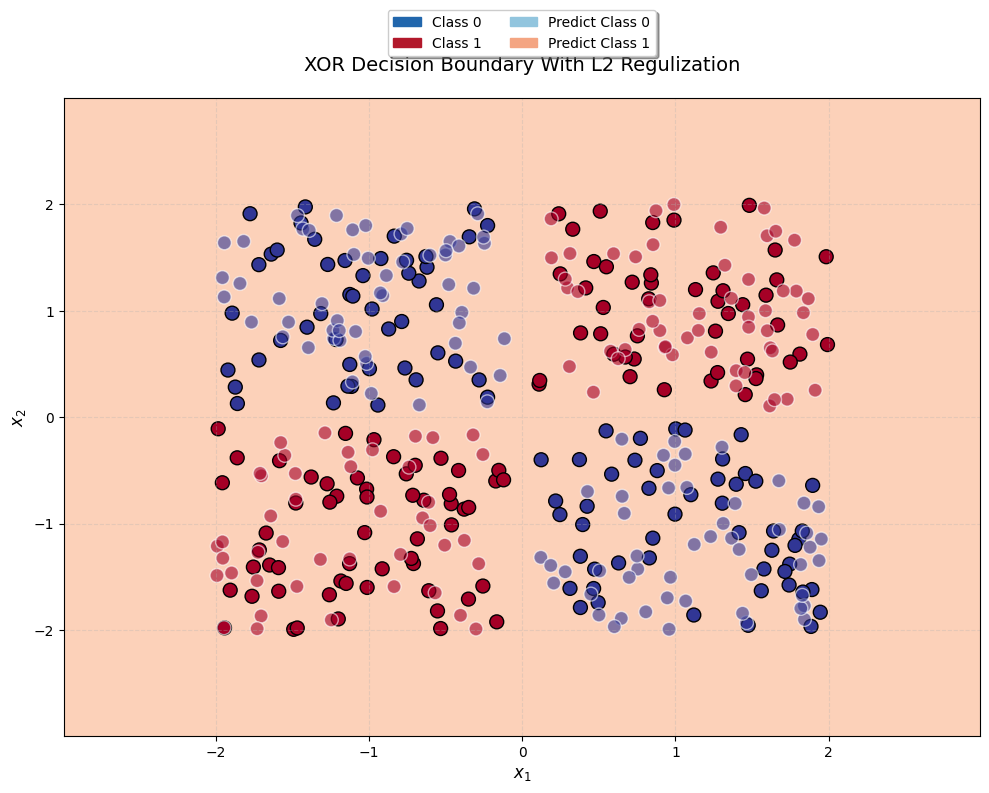

Epoch 1/1000, Loss: 0.7001
Epoch 101/1000, Loss: 0.0642
Epoch 201/1000, Loss: 0.0641
Epoch 301/1000, Loss: 0.0638
Epoch 401/1000, Loss: 0.0829
Epoch 501/1000, Loss: 0.0637
Epoch 601/1000, Loss: 0.0671
Epoch 701/1000, Loss: 0.0635
Epoch 801/1000, Loss: 0.1133
Epoch 901/1000, Loss: 0.0633
Accuracy: 0.9850


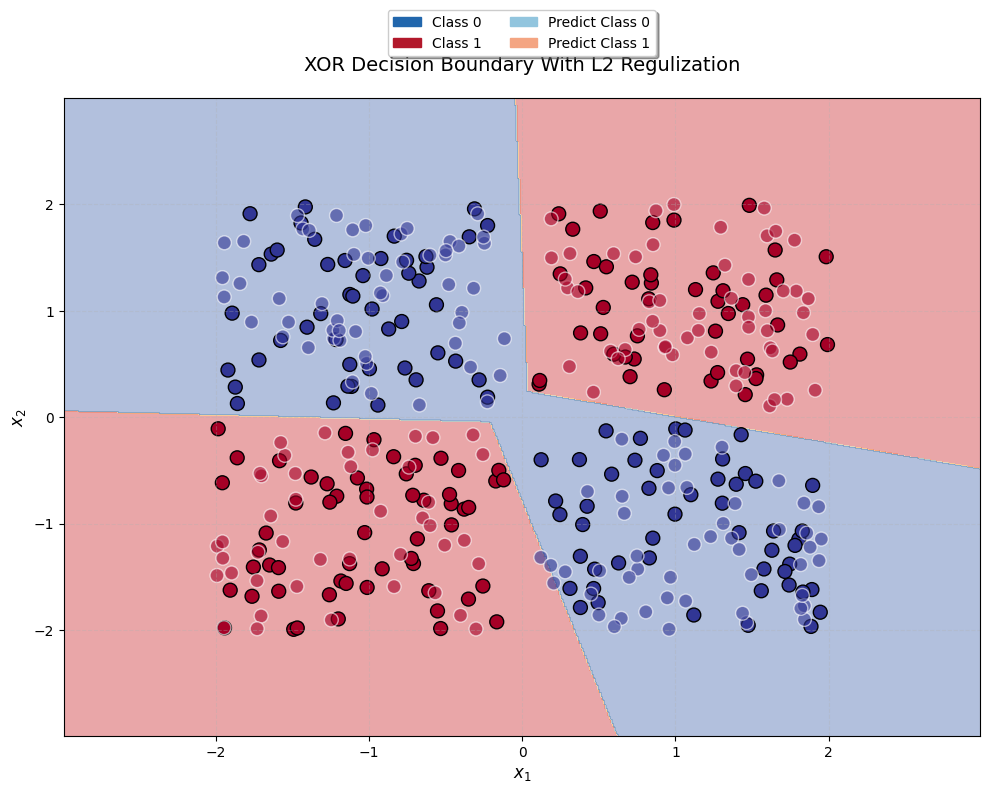

In [10]:
model_L2 = XORMLP(4, 3)
model_L2 = model_L2.to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_L2.parameters(), lr=0.03)


# Before Training
plot_decision_boundary(X_train, X_test, y_train, y_test, model_L2, "XOR Decision Boundary With L2 Regulization")    

# Train model with L2 regularization
loss_L2 = train_model(model_L2, loss_fn, optimizer, train_loader, regularization_type="L2",lamda=0.001)
evaluate_model(model_L2, test_loader)

# After Training
plot_decision_boundary(X_train, X_test, y_train, y_test, model_L2, "XOR Decision Boundary With L2 Regulization")

# **Logistic Regression using Polynomial Features**  

### Polynomial features transformation:
#### $$x_{\text{poly}} = [x_1^2, x_2^2, x_1 \cdot x_2]$$

### Logistic regression hypothesis:
#### $$\hat{y} = \frac{1}{1 + e^{-w^T x_{\text{poly}}}}$$

In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Move tensors to CPU before using sklearn functions
X_train_cpu = X_train.cpu().numpy()
X_test_cpu = X_test.cpu().numpy()

# Apply Polynomial Features transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_cpu)
X_test_poly = poly.transform(X_test_cpu)


# Logistic Regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train_poly, y_train.cpu().numpy())  # Also move labels to CPU

# Predictions
y_train_pred = logistic_reg.predict(X_train_poly)
y_test_pred = logistic_reg.predict(X_test_poly)

# Calculate accuracy
train_accuracy = accuracy_score(y_train.cpu().numpy(), y_train_pred)
test_accuracy = accuracy_score(y_test.cpu().numpy(), y_test_pred)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

Train Accuracy:  1.0
Test Accuracy:  1.0


# **Plotting Logistic Regression Decision Boundary**

In [13]:
import matplotlib.patches as mpatches
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_decision_boundary_sklearn(X_train, X_test, y_train, y_test, model, poly, title):
    # Move data to numpy arrays (assuming input is already numpy for sklearn)
    X_train_np = X_train.cpu().numpy() if isinstance(X_train, torch.Tensor) else X_train
    X_test_np = X_test.cpu().numpy() if isinstance(X_test, torch.Tensor) else X_test
    y_train_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
    y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

    # Calculate boundaries
    X = np.vstack([X_train_np, X_test_np])
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Create mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Transform mesh data using polynomial features
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    mesh_data_poly = poly.transform(mesh_data)  # Apply same polynomial transformation
    
    # Get predictions from the sklearn model
    Z = model.predict(mesh_data_poly)
    Z = Z.reshape(xx.shape)

    # Create plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.4)

    # Plot the training points
    plt.scatter(X_train_np[:, 0], X_train_np[:, 1], 
                c=y_train_np, cmap="RdYlBu", 
                s=100, label="Training Points",
                edgecolors='black', linewidth=1)
    
    # Plot the testing points
    plt.scatter(X_test_np[:, 0], X_test_np[:, 1], 
                c=y_test_np, cmap="RdYlBu", 
                s=100, alpha=0.6, label="Testing Points",
                edgecolors='white', linewidth=1)

    # Create legend patches
    class1_patch = mpatches.Patch(color='#2166ac', label='Class 0')
    class2_patch = mpatches.Patch(color='#b2182b', label='Class 1')
    pred1_patch = mpatches.Patch(color='#92c5de', label='Predict Class 0')
    pred2_patch = mpatches.Patch(color='#f4a582', label='Predict Class 1')

    # Add legend
    plt.legend(handles=[class1_patch, class2_patch, pred1_patch, pred2_patch],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.15),
               ncol=2,
               fancybox=True,
               shadow=True)

    # Customize plot
    plt.title(title, size=14, pad=20)
    plt.xlabel(r"$x_1$", size=12)
    plt.ylabel(r"$x_2$", size=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


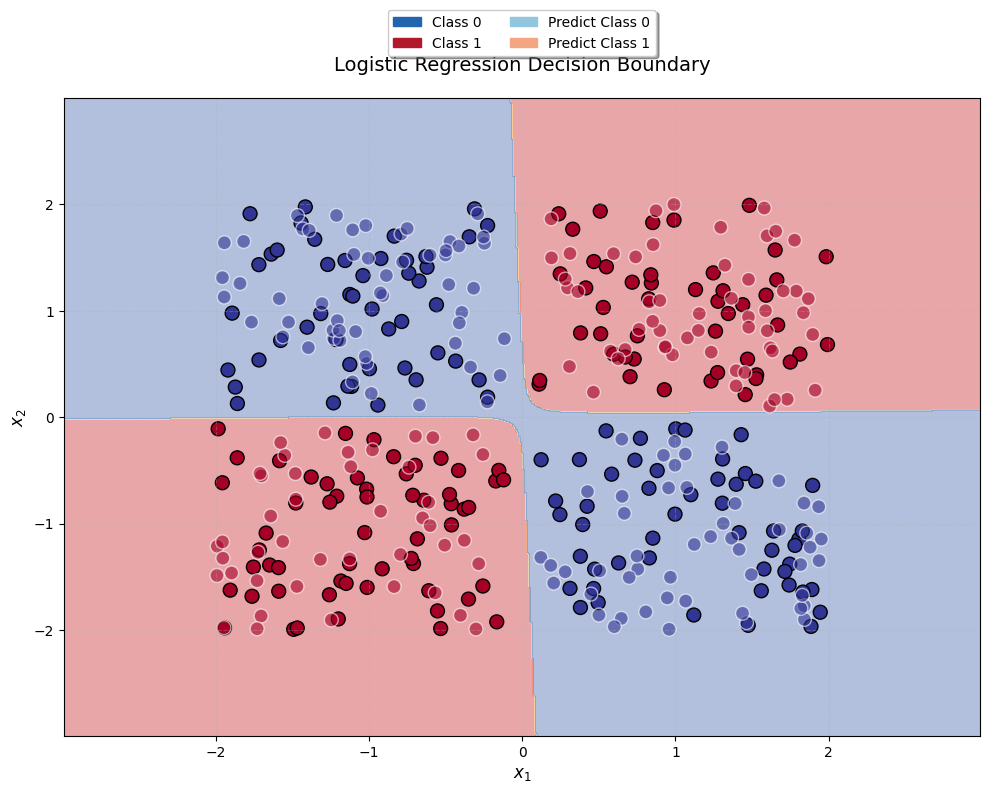

In [14]:
plot_decision_boundary_sklearn(X_train, X_test, y_train, y_test, logistic_reg, poly, "Logistic Regression Decision Boundary")

# **Select the Best Lambda** 

In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Assuming XORMLP, generate_xor_dataset, and other necessary functions are defined.

# Step 1: Generate XOR Dataset
size = 400  # Total number of samples
X, y = generate_xor_dataset(size)

# Split into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 of 80% = 20%

# Move tensors to device
X_train = X_train.float().to(device)
X_val = X_val.float().to(device)
X_test = X_test.float().to(device)
y_train = y_train.float().to(device)
y_val = y_val.float().to(device)
y_test = y_test.float().to(device)

# Create datasets and loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 2: Define the range of lambda values to try
lambda_values = [0.001, 0.01, 0.1, 1, 10]

# Step 3: Train and validate model for each lambda
def train_and_validate_model(model, loss_fn, optimizer, train_loader, val_loader, lambda_values, regularization_type=None, epochs=1000):
    best_lambda = None
    best_val_loss = float('inf')
    
    for lamda in lambda_values:
        print(f"Training with lambda: {lamda:.4f}")
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            
            for inputs, targets in train_loader:
                inputs = inputs.float().to(device)
                targets = targets.float().to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs.squeeze(), targets)
                
                # Apply regularization
                if regularization_type == 'L1':
                    l1_norm = sum(p.abs().sum() for p in model.parameters())
                    loss += lamda * l1_norm
                elif regularization_type == 'L2':
                    l2_norm = sum(p.pow(2).sum() for p in model.parameters())
                    loss += lamda * l2_norm
                
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
        
        # Validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.float().to(device)
                targets = targets.float().to(device)
                outputs = model(inputs)
                val_loss += loss_fn(outputs.squeeze(), targets).item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        print(f"Validation Loss with lambda {lamda:.4f}: {val_loss:.4f}")

        # Check if this lambda gives a better validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_lambda = lamda
    
    print(f"Best lambda: {best_lambda:.4f} with validation loss: {best_val_loss:.4f}")
    return best_lambda

# Initialize model
model_1 = XORMLP(4, 3)
model_1 = model_1.to(device)

# Define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.03)

In [16]:
best_lambda = train_and_validate_model(model_1, loss_fn, optimizer, train_loader, val_loader, lambda_values, regularization_type='L1')

Training with lambda: 0.0010
Validation Loss with lambda 0.0010: 0.0100
Training with lambda: 0.0100
Validation Loss with lambda 0.0100: 0.0394
Training with lambda: 0.1000
Validation Loss with lambda 0.1000: 0.6931
Training with lambda: 1.0000
Validation Loss with lambda 1.0000: 0.6930
Training with lambda: 10.0000
Validation Loss with lambda 10.0000: 0.6931
Best lambda: 0.0010 with validation loss: 0.0100


In [10]:
model_2 = XORMLP(4, 3)
model_2 = model_2.to(device)

# Define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.03)

In [11]:
best_lambda = train_and_validate_model(model_2, loss_fn, optimizer, train_loader, val_loader, lambda_values, regularization_type='L2')

Training with lambda: 0.0010
Validation Loss with lambda 0.0010: 0.0081
Training with lambda: 0.0100
Validation Loss with lambda 0.0100: 0.0960
Training with lambda: 0.1000
Validation Loss with lambda 0.1000: 0.6932
Training with lambda: 1.0000
Validation Loss with lambda 1.0000: 0.6930
Training with lambda: 10.0000
Validation Loss with lambda 10.0000: 0.6933
Best lambda: 0.0010 with validation loss: 0.0081
